# Activity - 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit
#import numpy as np
#import matplotlib.pyplot as plt

In [2]:
data_x = {} #create dictionaries
data_y = {}

for N in (10, 100, 1000):
    hf = h5py.File(f'/Users/antarapaul/Desktop/PHY657_new/PHY657/Module_3/data_N{N}.h5', 'r')
    data_x[N] = hf['x'][()]
    data_y[N] = hf['y'][()]
    
#print(data_x[1000], data_y[1000])
#X_train, Y_train = data_x[1000], data_y[1000]

In [8]:
import numpy as np

class MLP:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1
        print('num layers',self.num_layers)
        # Initialize the weights and biases for each layer
        self.weights = []
        self.biases = []
        sizes = [input_size] + hidden_sizes + [output_size]
        print(sizes)
        for i in range(1, self.num_layers + 1):
            self.weights.append(np.random.randn(sizes[i], sizes[i-1]))
            #print(self.weights)
            self.biases.append(np.random.randn(sizes[i], 1))
        #print(self.biases)

    def forward_regression(self, X):
        # Forward propagation through the network
        #print(X.shape)
        self.activations = [X]
        self.z = []
        for i in range(self.num_layers):
            z = np.dot(self.weights[i], self.activations[i]) + self.biases[i]
            self.z.append(z)
            if i < self.num_layers - 1:
                a = self.tanh(z)  # Tanh activation for hidden layers
            else:
                a = z  # Linear activation for output layer
            self.activations.append(a)
        #print(self.activations[-1])
        return self.activations[-1]  # shape: (output_size, m)

    def forward_classification(self, X):
        # Forward propagation through the network
        #print(X.shape)
        self.activations = [X]
        self.z = []
        for i in range(self.num_layers):
            z = np.dot(self.weights[i], self.activations[i]) + self.biases[i]
            self.z.append(z)
            if i < self.num_layers - 1:
                a = self.tanh(z)  # Tanh activation for hidden layers
            else:
                a = self.sigmoid(z) # Linear activation for output layer
            self.activations.append(a)
        #print(self.activations[-1])
        return self.activations[-1]  # shape: (output_size, m)
    

    def backward_regression(self, X, y):
        m = X.shape[1]  # Number of training examples

        # Compute gradients
        gradients = []
        dZ = self.activations[-1] - y  # shape: (output_size, m)
        for i in range(self.num_layers - 1, -1, -1):
            dW = (1 / m) * np.dot(dZ, self.activations[i].T)  # shape: (sizes[i], sizes[i-1])
            db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)  # shape: (sizes[i], 1)
            gradients.append((dW, db))

            if i > 0:
                dA = np.dot(self.weights[i].T, dZ)  # shape: (sizes[i-1], m)
                dZ = dA * self.gradient_tanh(self.z[i-1])  # shape: (sizes[i-1], m)

        return gradients[::-1]  # Reverse the gradients



    def backward_classification(self, X, y):
        m = X.shape[1]  # Number of training examples

        # Initialize gradients list
        gradients = []

        # Step 1: Output layer - Compute dZ for the output layer
        # Binary Cross-Entropy loss derivative with respect to output
        dA_output = self.activations[-1] - y  # This is the gradient of the loss w.r.t output
        dZ_output = dA_output * self.gradient_sigmoid(self.z[-1])  # Sigmoid derivative

        # Compute gradients for weights and biases at the output layer
        dW_output = (1 / m) * np.dot(dZ_output, self.activations[-2].T)  # dW = dZ * a^T (for weights)
        db_output = (1 / m) * np.sum(dZ_output, axis=1, keepdims=True)  # db = sum(dZ)

       # Append output layer gradients to list
        gradients.append((dW_output, db_output))

       # Step 2: Backpropagate through hidden layers
       # Loop through hidden layers (starting from the second to last layer)
        for i in range(self.num_layers - 1, 0, -1):
            dA = np.dot(self.weights[i].T, dZ_output)  # dA = W^T * dZ
            dZ = dA * self.gradient_tanh(self.z[i - 1])  # Apply gradient of tanh for hidden layers

        # Compute gradients for weights and biases in hidden layers
        dW = (1 / m) * np.dot(dZ, self.activations[i - 1].T)  # dW = dZ * a^T
        db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)  # db = sum(dZ)

        # Append hidden layer gradients to list
        gradients.append((dW, db))

        # Update dZ_output for the next layer
        dZ_output = dZ

    # Reverse the order of gradients to correspond to layers' order
        return gradients[::-1]  # Reverse the order for correct layer-wise gradients


    def update_parameters(self, gradients, learning_rate):
        # Update parameters using gradients and learning rate
        for i in range(self.num_layers):
            self.weights[i] -= learning_rate * gradients[i][0]
            self.biases[i] -= learning_rate * gradients[i][1]


    def cross_entropy_loss(self, y_pred, y_true):
    # Binary cross-entropy loss for binary classification
        epsilon = 1e-15  # To avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Prevent log(0)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=0))

    def compute_loss(self, y_pred, y_true):
    # For multi-class classification
        if y_true.shape[0] == 1:  # Binary classification
            return self.cross_entropy_loss(y_pred, y_true)
        else:
            return self.cross_entropy_loss(y_pred, y_true)

    def tanh(self, Z):
        # Hyperbolic tangent (tanh) activation function
        return np.tanh(Z)

    def gradient_tanh(self, Z):
        # Gradient of the hyperbolic tangent (tanh) activation function
        return 1 - np.tanh(Z)**2

    def sigmoid(self, Z):
        return 1/(1 + np.exp(-Z))

        
    def gradient_sigmoid(self, Z):
        sig = self.sigmoid(Z)
        return sig * (1 - sig)  # Derivative of sigmoid

# Regression

800
input size 1
num layers 2
[1, 10, 1]


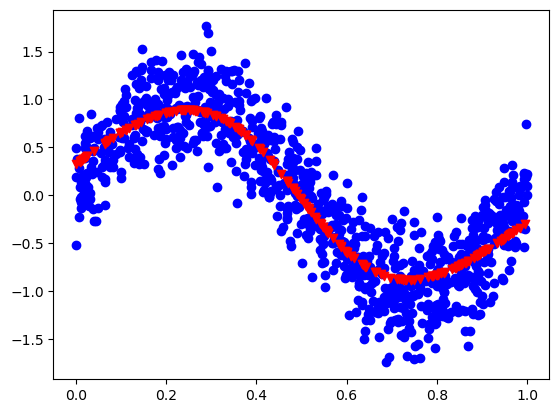

In [81]:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import numpy as np

    X, y = data_x[1000], data_y[1000]
    #print(X.shape)
    plt.scatter(X,y,marker='o',color='blue')
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

    # correct sizes = (sample_size, m) here m = 1
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Define the MLP model
    input_size = X_train.shape[1]
    print(X_train.shape[0]) 
    print('input size',input_size)
    hidden_sizes = [10, ]   #only one hidden layer
    output_size = y_train.shape[1]
    mlp = MLP(input_size, hidden_sizes, output_size)

    # Training parameters
    num_epochs = 30000
    learning_rate = 0.01

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        outputs = mlp.forward_regression(X_train.T)    #transpose is taken because we will do dot product with the weight vectors. there it should be
        # W.X^T.

        # Backward pass and parameter update
        gradients = mlp.backward_regression(X_train.T, y_train.T)
        mlp.update_parameters(gradients, learning_rate)

        # Compute and print loss
        loss = np.mean((outputs - y_train.T) ** 2)
        # if (epoch + 1) % 300 == 0:
        #     print(f"Epoch {epoch+1} - Loss: {loss}")

    # Testing

    test_outputs = mlp.forward_regression(X_test.T)
    test_loss = np.mean((test_outputs - y_test.T) ** 2)

    plt.scatter(X_test, test_outputs.T,marker='v',color='red')
    #print(f"Test Loss: {test_loss}")

# Classification

In [36]:
#red points in Bishop
#mu1 = [1.5, -2]  
mu1 = [3.8, 1.5]
cov1 = [[0.8596, 0.1502], [0.1502, 0.3397]]
sample1 = np.random.multivariate_normal(mu1, cov1, 200) #class1


#blue points in Bishop
mu2 = [1, 2.8]  
cov2 = [[0.8596, 0.1502], [0.1502, 0.3397]]
sample2 = np.random.multivariate_normal(mu2, cov2, 200) #class2


X_class = np.append(sample1, sample2, axis=0) # X = [X1, X2] = [X1, X2] from sample1 and sample2 are stacked together = (row = N, column = 2)
# = np.append[(row = N/2, column = 2), (row = N/2, column = 2)]
#print(X)
Y_class = np.append([1 for points in sample1], [-1 for points in sample2], axis=0) # Y = (row = N, column = 2) = target vector


X_class_train, X_class_test, Y_class_train, Y_class_test = train_test_split(X_class, Y_class, test_size=0.20, random_state=42)
sample1_train = X_class_train[Y_class_train == 1]  # Extract points where Y_train == 1
sample2_train = X_class_train[Y_class_train == -1]  # Extract points where Y_train == -1

print(Y_class_train.reshape(-1, 1).shape)

(320, 1)


input size 2
num layers 2
[2, 10, 1]


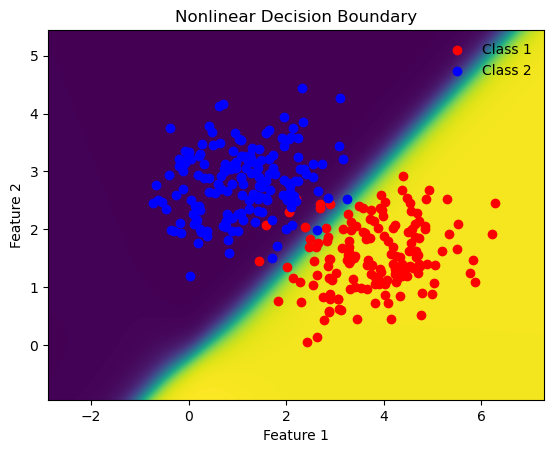

In [152]:
if __name__ == "__main__":

    # correct sizes = (sample_size, m) here m = 1
    Y_class_train = Y_class_train.reshape(-1, 1)
    Y_class_test = Y_class_test.reshape(-1, 1)

    # Define the MLP model
    input_size = X_class_train.shape[1]
    #print(X_train.shape[0]) 
    print('input size',input_size)
    hidden_sizes = [10, ]   #only one hidden layer
    output_size = Y_class_train.shape[1]
    mlp = MLP(input_size, hidden_sizes, output_size)

    # Training parameters
    num_epochs = 30000
    learning_rate = 0.01

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        outputs = mlp.forward_classification(X_class_train.T)    #transpose is taken because we will do dot product with the weight vectors. there it should be
        # W.X^T.

        # Backward pass and parameter update
        gradients = mlp.backward_classification(X_class_train.T, Y_class_train.T)
        mlp.update_parameters(gradients, learning_rate)

        # Compute and print loss
        loss = mlp.compute_loss(outputs, Y_class_train.T)  # Use classification loss
        #if (epoch + 1) % 100 == 0:
            #print(f"Epoch {epoch+1} - Loss: {loss}")

# Testing
    test_outputs = mlp.forward_classification(X_class_test.T)
    test_loss = mlp.compute_loss(test_outputs, Y_class_test.T)
    #print(f"Test Loss: {test_loss}")

    # Define grid
    x_min, x_max = X_class[:, 0].min() - 1, X_class[:, 0].max() + 1
    y_min, y_max = X_class[:, 1].min() - 1, X_class[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Flatten grid and pass through MLP
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = mlp.forward_classification(grid_points.T).T
    predictions = predictions.reshape(xx.shape)
    
    # Convert continuous values to binary predictions (e.g., > 0.5 -> class 1, else class -1)
    # predictions_binary = (predictions > 0.5).astype(int)
    # predictions_binary = predictions_binary.reshape(xx.shape)
    
    
    # Plot decision boundary
    plt.contourf(xx, yy, predictions, levels=np.linspace(0, 1, 1000))

    # Plot training points for class 1 and class 2
    plt.scatter(sample1_train[:, 0], sample1_train[:, 1], color='red', label='Class 1')
    plt.scatter(sample2_train[:, 0], sample2_train[:, 1], color='blue', label='Class 2')
    
    plt.legend(frameon=False)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Nonlinear Decision Boundary")
    plt.show()

# Activity - 2

# Using scikit-learn

## varying both no. of nodes in a hidden layer and no. of hidden layers 

In [147]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

X, y = data_x[1000], data_y[1000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 #y data is just 1D so only need to reshape x data for MLP regressor
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

hidden_sizes_list = [
    (10,),    
    (10, 10, 10,),    
    (10, 10, 10, 10, 10, 10,),
    (20,),
    (20, 20, 20,),    
    (20, 20, 20, 20, 20, 20,),
    (80,),
    (80, 80, 80,),    
    (80, 80, 80, 80, 80, 80,),
    (150,),
    (150, 150, 150,),    
    (150, 150, 150, 150, 150, 150,),
    (1000,),
    (1000, 1000, 1000,),    
    (1000, 1000, 1000, 1000, 1000, 1000,),
    (10, 50, 100, 200, 500, 1000)
    ]

#default solver and activation give the best r2 score
for hidden_size in hidden_sizes_list:
    mlp = MLPRegressor(hidden_layer_sizes=hidden_size, solver= 'adam', activation = 'relu', max_iter=1000, random_state=42) 
    mlp.fit(X_train, y_train)
    
    # Predicting and evaluating R² score
    y_pred = mlp.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f"r2 Score for {hidden_size} nodes: {r2:.4f}")

r2 Score for (10,) nodes: 0.5490
r2 Score for (10, 10, 10) nodes: 0.8524
r2 Score for (10, 10, 10, 10, 10, 10) nodes: 0.8548
r2 Score for (20,) nodes: 0.5922
r2 Score for (20, 20, 20) nodes: 0.8497
r2 Score for (20, 20, 20, 20, 20, 20) nodes: 0.8409
r2 Score for (80,) nodes: 0.8386
r2 Score for (80, 80, 80) nodes: 0.8525
r2 Score for (80, 80, 80, 80, 80, 80) nodes: 0.8498
r2 Score for (150,) nodes: 0.8432
r2 Score for (150, 150, 150) nodes: 0.8554
r2 Score for (150, 150, 150, 150, 150, 150) nodes: 0.8428
r2 Score for (1000,) nodes: 0.8444
r2 Score for (1000, 1000, 1000) nodes: 0.8510
r2 Score for (1000, 1000, 1000, 1000, 1000, 1000) nodes: 0.8469
r2 Score for (10, 50, 100, 200, 500, 1000) nodes: 0.8441


### varying no. of iterations

In [150]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

X, y = data_x[1000], data_y[1000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 #y data is just 1D so only need to reshape x data for MLP regressor
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

iter_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000]

#default solver and activation give the best r2 score
for iteration in iter_list:
    mlp = MLPRegressor(hidden_layer_sizes=hidden_size, solver= 'adam', activation = 'relu', max_iter=iteration, random_state=42) 
    mlp.fit(X_train, y_train)
    
    # Predicting and evaluating R² score
    y_pred = mlp.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f"r2 Score for {iteration} epochs: {r2:.4f}")

/Users/antarapaul/miniforge3/envs/root-etc/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


r2 Score for 10 epochs: 0.6872
r2 Score for 50 epochs: 0.8441
r2 Score for 100 epochs: 0.8441
r2 Score for 500 epochs: 0.8441
r2 Score for 1000 epochs: 0.8441
r2 Score for 5000 epochs: 0.8441
r2 Score for 10000 epochs: 0.8441
r2 Score for 50000 epochs: 0.8441


# Using the MLP from scratch

## no. of nodes in hidden layer keeping only one hidden layer

8
input size 1
Training with hidden sizes: [8]
num layers 2
[1, 8, 1]
Training with hidden sizes: [50]
num layers 2
[1, 50, 1]
Training with hidden sizes: [200]
num layers 2
[1, 200, 1]


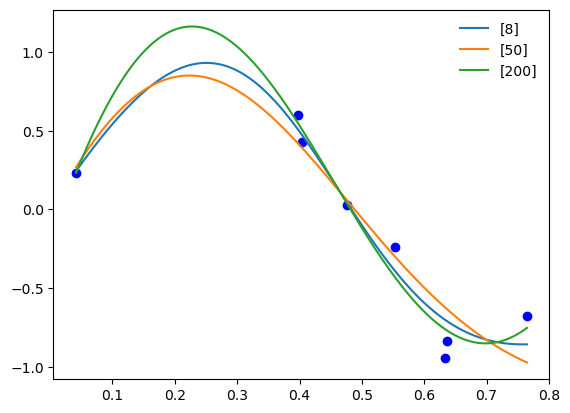

In [121]:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import numpy as np

    X, y = data_x[10], data_y[10]
    #print(X.shape)
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
    #X_train = (input_data_size, m) m is number of x_m vectors. for sinusoidal example, m = 1 and input size = sample size.
    

    # Normalize the input data
    # X_train_mean = np.mean(X_train)
    # X_train_std = np.std(X_train)
    # X_train = (X_train - X_train_mean) / X_train_std
    # X_test = (X_test - X_train_mean) / X_train_std


    # correct sizes = (sample_size, m) here m = 1
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    plt.scatter(X_train,y_train,marker='o',color='blue')

    # Define the MLP model
    input_size = X_train.shape[1]
    print(X_train.shape[0]) 
    print('input size',input_size)
    #hidden_sizes = [500, ]   #only one hidden layer
    hidden_sizes_list = [
    [8],    # Configuration 1: one hidden layer with 10 nodes
    [50],    # Configuration 2: one hidden layer with 20 nodes
    [200] # Configuration 3: one hidden layer with 30 nodes
    ]
    output_size = y_train.shape[1]
    
    for hidden_sizes in hidden_sizes_list:
        print(f"Training with hidden sizes: {hidden_sizes}")
        mlp = MLP(input_size, hidden_sizes, output_size)
    
        # Training parameters
        num_epochs = 30000
        learning_rate = 0.01
    
        # Training loop
        for epoch in range(num_epochs):
            # Forward pass
            outputs = mlp.forward_regression(X_train.T)    #transpose is taken because we will do dot product with the weight vectors. there it should be
            # W.X^T.
    
            # Backward pass and parameter update
            gradients = mlp.backward_regression(X_train.T, y_train.T)
            mlp.update_parameters(gradients, learning_rate)
    
            # Compute and print loss
            loss = np.mean((outputs - y_train.T) ** 2)
            # if (epoch + 1) % 300 == 0:
            #     print(f"Epoch {epoch+1} - Loss: {loss}")
    
        # Testing
        
        X_cont = np.linspace(X_train.min(), X_train.max(), 1000)
        X_cont = X_cont.reshape(-1,1)
        test_outputs = mlp.forward_regression(X_cont.T)
        #test_loss = np.mean((test_outputs - y_test.T) ** 2)
        
        plt.plot(X_cont, test_outputs.T, label=f'{hidden_sizes}')
    #print(f"Test Loss: {test_loss}")

plt.legend(frameon = False)
plt.show()

## no. of hidden layers keeping same number of nodes

80
input size 1
Training with hidden sizes: [10, 10]
num layers 3
[1, 10, 10, 1]
Training with hidden sizes: [10, 10, 10]
num layers 4
[1, 10, 10, 10, 1]
Training with hidden sizes: [10, 10, 10, 10, 10]
num layers 6
[1, 10, 10, 10, 10, 10, 1]
Training with hidden sizes: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
num layers 11
[1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1]


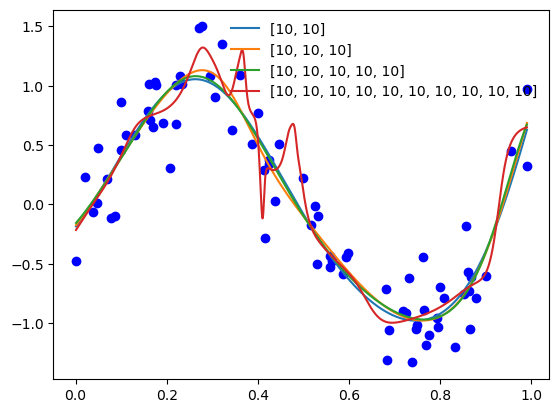

In [122]:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import numpy as np

    X, y = data_x[100], data_y[100]
    #print(X.shape)
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

    # correct sizes = (sample_size, m) here m = 1
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    plt.scatter(X_train,y_train,marker='o',color='blue')

    # Define the MLP model
    input_size = X_train.shape[1]
    print(X_train.shape[0]) 
    print('input size',input_size)
    #hidden_sizes = [500, ]   #only one hidden layer
    hidden_sizes_list = [
    [10, 10],     
    [10, 10, 10],     
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
    ]
    output_size = y_train.shape[1]
    
    for hidden_sizes in hidden_sizes_list:
        print(f"Training with hidden sizes: {hidden_sizes}")
        mlp = MLP(input_size, hidden_sizes, output_size)
    
        # Training parameters
        num_epochs = 30000
        learning_rate = 0.01
    
        # Training loop
        for epoch in range(num_epochs):
            # Forward pass
            outputs = mlp.forward_regression(X_train.T)    #transpose is taken because we will do dot product with the weight vectors. there it should be
            # W.X^T.
    
            # Backward pass and parameter update
            gradients = mlp.backward_regression(X_train.T, y_train.T)
            mlp.update_parameters(gradients, learning_rate)
    
            # Compute and print loss
            loss = np.mean((outputs - y_train.T) ** 2)
            # if (epoch + 1) % 300 == 0:
            #     print(f"Epoch {epoch+1} - Loss: {loss}")
    
        # Testing
        
        X_cont = np.linspace(X_train.min(), X_train.max(), 1000)
        X_cont = X_cont.reshape(-1,1)
        test_outputs = mlp.forward_regression(X_cont.T)
        #test_loss = np.mean((test_outputs - y_test.T) ** 2)
        
        plt.plot(X_cont, test_outputs.T, label=f'{hidden_sizes}')
    #print(f"Test Loss: {test_loss}")

plt.legend(frameon = False)
plt.show()

## no. of iterations

8
input size 1
num layers 2
[1, 10, 1]
Num of epochs: 30
Num of epochs: 300
Num of epochs: 3000
Num of epochs: 30000


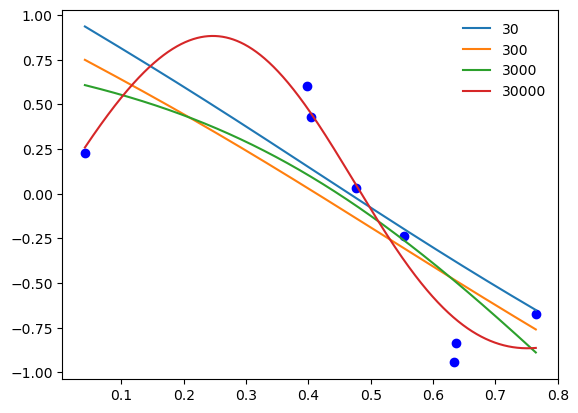

In [120]:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import numpy as np

    X, y = data_x[10], data_y[10]
    #print(X.shape)
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

    # correct sizes = (sample_size, m) here m = 1
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    plt.scatter(X_train,y_train,marker='o',color='blue')

    # Define the MLP model
    input_size = X_train.shape[1]
    print(X_train.shape[0]) 
    print('input size',input_size)
    #hidden_sizes = [500, ]   #only one hidden layer
    hidden_sizes = [10]    # Configuration 1: one hidden layer with 10 nodes
    mlp = MLP(input_size, hidden_sizes, output_size)
    
    output_size = y_train.shape[1]

    epochs_list = [30, 300, 3000, 30000]
    
    for num_epochs in epochs_list:
        print(f"Num of epochs: {num_epochs}")
    
        # Training parameters
        #num_epochs = 30000
        learning_rate = 0.01
    
        # Training loop
        for epoch in range(num_epochs):
            # Forward pass
            outputs = mlp.forward_regression(X_train.T)    #transpose is taken because we will do dot product with the weight vectors. there it should be
            # W.X^T.
    
            # Backward pass and parameter update
            gradients = mlp.backward_regression(X_train.T, y_train.T)
            mlp.update_parameters(gradients, learning_rate)
    
            # Compute and print loss
            loss = np.mean((outputs - y_train.T) ** 2)
            # if (epoch + 1) % 300 == 0:
            #     print(f"Epoch {epoch+1} - Loss: {loss}")
    
        # Testing
        
        X_cont = np.linspace(X_train.min(), X_train.max(), 1000)
        X_cont = X_cont.reshape(-1,1)
        test_outputs = mlp.forward_regression(X_cont.T)
        #test_loss = np.mean((test_outputs - y_test.T) ** 2)
        
        plt.plot(X_cont, test_outputs.T, label=f'{num_epochs}')
    #print(f"Test Loss: {test_loss}")

plt.legend(frameon = False)
plt.show()

# Activity - 3

In [2]:
import pandas as pd

# Define column names (since the dataset doesn't include headers)
column_names = ["Feature 0", "Feature 1", "Feature 2", "Feature 3", "species"]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, names=column_names)

# Display the first few rows
print(df.head(50))

    Feature 0  Feature 1  Feature 2  Feature 3      species
0         5.1        3.5        1.4        0.2  Iris-setosa
1         4.9        3.0        1.4        0.2  Iris-setosa
2         4.7        3.2        1.3        0.2  Iris-setosa
3         4.6        3.1        1.5        0.2  Iris-setosa
4         5.0        3.6        1.4        0.2  Iris-setosa
5         5.4        3.9        1.7        0.4  Iris-setosa
6         4.6        3.4        1.4        0.3  Iris-setosa
7         5.0        3.4        1.5        0.2  Iris-setosa
8         4.4        2.9        1.4        0.2  Iris-setosa
9         4.9        3.1        1.5        0.1  Iris-setosa
10        5.4        3.7        1.5        0.2  Iris-setosa
11        4.8        3.4        1.6        0.2  Iris-setosa
12        4.8        3.0        1.4        0.1  Iris-setosa
13        4.3        3.0        1.1        0.1  Iris-setosa
14        5.8        4.0        1.2        0.2  Iris-setosa
15        5.7        4.4        1.5     

In [3]:
print(df[50:100])

    Feature 0  Feature 1  Feature 2  Feature 3          species
50        7.0        3.2        4.7        1.4  Iris-versicolor
51        6.4        3.2        4.5        1.5  Iris-versicolor
52        6.9        3.1        4.9        1.5  Iris-versicolor
53        5.5        2.3        4.0        1.3  Iris-versicolor
54        6.5        2.8        4.6        1.5  Iris-versicolor
55        5.7        2.8        4.5        1.3  Iris-versicolor
56        6.3        3.3        4.7        1.6  Iris-versicolor
57        4.9        2.4        3.3        1.0  Iris-versicolor
58        6.6        2.9        4.6        1.3  Iris-versicolor
59        5.2        2.7        3.9        1.4  Iris-versicolor
60        5.0        2.0        3.5        1.0  Iris-versicolor
61        5.9        3.0        4.2        1.5  Iris-versicolor
62        6.0        2.2        4.0        1.0  Iris-versicolor
63        6.1        2.9        4.7        1.4  Iris-versicolor
64        5.6        2.9        3.6     

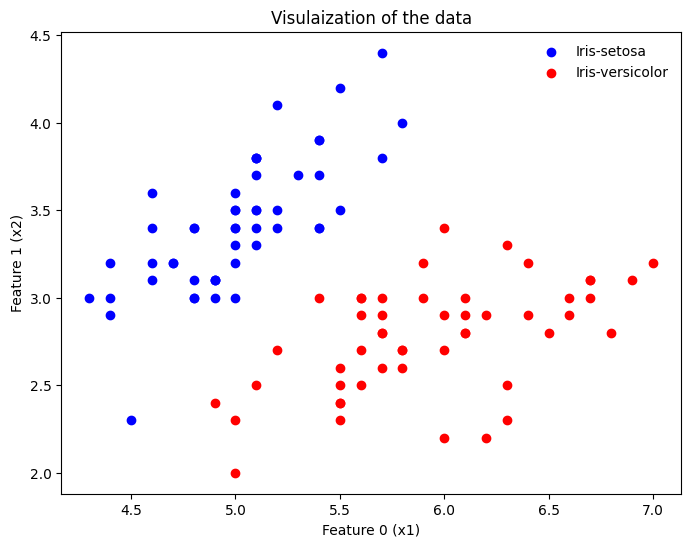

In [10]:
df = df.rename(columns={"Feature 0": "x1", "Feature 1": "x2"})

df_filtered = df[df["species"].isin(["Iris-setosa", "Iris-versicolor"])]

plt.figure(figsize=(8,6))

# Plot the two classes
plt.scatter(df_filtered[df_filtered['species'] == 'Iris-setosa']['x1'], 
            df_filtered[df_filtered['species'] == 'Iris-setosa']['x2'], 
            label='Iris-setosa', color='blue')

plt.scatter(df_filtered[df_filtered['species'] == 'Iris-versicolor']['x1'], 
            df_filtered[df_filtered['species'] == 'Iris-versicolor']['x2'], 
            label='Iris-versicolor', color='red')

# Labels and title
plt.xlabel('Feature 0 (x1)')
plt.ylabel('Feature 1 (x2)')
plt.title('Visulaization of the data')
plt.legend(frameon = False)
plt.savefig('Activity-3_points')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
sample1 = df_filtered[df_filtered['species'] == 'Iris-setosa'][['x1', 'x2']].values  # Setosa samples
sample2 = df_filtered[df_filtered['species'] == 'Iris-versicolor'][['x1', 'x2']].values  # Versicolor samples

X_class = np.append(sample1, sample2, axis=0)

Y_class = np.append([1 for _ in sample1], [-1 for _ in sample2], axis=0)

# Split into training and testing sets
X_class_train, X_class_test, Y_class_train, Y_class_test = train_test_split(X_class, Y_class, test_size=0.40)

sample1_train = X_class_train[Y_class_train == 1]  # Points where Y_train == 1 (Iris-setosa)
sample2_train = X_class_train[Y_class_train == -1]  # Points where Y_train == -1 (Iris-versicolor)
print(Y_class_train)
print("Training labels shape:", Y_class_train.reshape(-1, 1).shape)

[-1 -1  1  1  1  1  1 -1 -1  1  1  1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1
 -1  1 -1  1  1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1
  1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1]
Training labels shape: (60, 1)


In [9]:
if __name__ == "__main__":

    # correct sizes = (sample_size, m) here m = 1
    Y_class_train = Y_class_train.reshape(-1, 1)
    Y_class_test = Y_class_test.reshape(-1, 1)

    # Define the MLP model
    input_size = X_class_train.shape[1]
    #print(X_train.shape[0]) 
    print('input size',input_size)
    hidden_sizes = [10, ]   #only one hidden layer
    output_size = Y_class_train.shape[1]
    mlp = MLP(input_size, hidden_sizes, output_size)

    # Training parameters
    num_epochs = 5000
    learning_rate = 0.01

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        outputs = mlp.forward_classification(X_class_train.T)    #transpose is taken because we will do dot product with the weight vectors. there it should be
        # W.X^T.

        # Backward pass and parameter update
        gradients = mlp.backward_classification(X_class_train.T, Y_class_train.T)
        mlp.update_parameters(gradients, learning_rate)

        # Compute and print loss
        loss = mlp.compute_loss(outputs, Y_class_train.T)  # Use classification loss
        #if (epoch + 1) % 100 == 0:
            #print(f"Epoch {epoch+1} - Loss: {loss}")

# Testing
    test_outputs = mlp.forward_classification(X_class_test.T)
    test_loss = mlp.compute_loss(test_outputs, Y_class_test.T)
    print(f"Test Loss: {test_loss}")
    print(test_outputs)
    
    test_pred = (test_outputs > 0.5).astype(int)  # If output > 0.5, predict class 1; else, predict class -1
    test_pred = 2 * test_pred - 1
    print("Y test predicted and converted to +1 and -1: \n", test_pred)
    print("Y test data: \n", Y_class_test.T)
    misclassified = np.sum(test_pred != Y_class_test.T)  # Compare predictions with true labels

    # Print the number of misclassified points
    print(f"Number of misclassified points: {misclassified}")

input size 2
num layers 2
[2, 10, 1]
Test Loss: -2.461700502915652
[[5.82467703e-01 9.70665348e-01 9.27464536e-01 9.20162789e-01
  7.66970515e-01 9.59654951e-01 4.78087206e-03 4.29786945e-03
  9.72650644e-01 9.48153976e-01 7.71400516e-01 4.47227715e-01
  5.50371962e-03 9.63766264e-01 8.03733499e-04 9.55991709e-01
  1.88917871e-03 2.10577273e-03 2.77485393e-03 9.84782436e-01
  1.59171746e-03 1.15883625e-03 8.72974695e-01 9.60263370e-01
  1.24735536e-03 7.71400516e-01 1.24955604e-03 2.07087846e-03
  2.28220371e-03 2.13128414e-02 2.50938456e-03 9.48153976e-01
  1.85074707e-02 7.66970515e-01 9.39009171e-01 1.20759388e-01
  9.02675855e-04 2.30566874e-03 9.78847170e-01 9.78847170e-01]]
Y test predicted and converted to +1 and -1: 
 [[ 1  1  1  1  1  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1  1
  -1  1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1  1  1]]
Y test data: 
 [[ 1  1  1  1  1  1 -1 -1  1  1  1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1  1
  -1  1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1 -1  1  1